In [2]:
import pandas as pd
 
#this assumes one json item per line in json file
df=pd.read_csv('cleaned_products.csv', sep=',',header=0, lineterminator='\n')

In [2]:
df.dtypes

Unnamed: 0               int64
id                      object
product_name            object
category                object
product_description     object
price                  float64
location                object
dtype: object

In [3]:
#number of rows (datapoints)
len(df)

7156

In [4]:
df.sample(100)

,Unnamed: 0,id,product_name,category,product_description,price,location
5812,5812,3a2b39ea-8af9-40dd-8215-42726c78ca69,"Mobility scooter for sale | in Ipswich, Suffol...","Health & Beauty / Mobility, Disability & Medical",Mobility scooter for sale . It’s in working or...,200.00,"Ipswich, Suffolk"
2011,2011,c53a2298-5baa-45e7-9cfa-8c12f0ca7f7a,"Illuminated Birthday party signs | in Cosham, ...",Other Goods / Other,Big Brights hire out illuminated party signs f...,40.00,"Cosham, Hampshire"
4005,4005,cd5446a5-a851-4486-aa81-6355f77ffa7c,"Captain America - Civil War - DVD | in Woking,...","Music, Films, Books & Games / Films & TV / DVDs",Director Anthony & Joe Russo. Starring Robert ...,4.00,"Woking, Surrey"
2511,2511,4596e8b6-ff33-4da6-9328-44477e2f39cb,"Vibration plate | in Restalrig, Edinburgh | Gu...","Sports, Leisure & Travel / Fitness & Gym Equip...",Vibration plate hardly used needs gone as its ...,70.00,"Restalrig, Edinburgh"
4900,4900,80b4aa2e-4c64-46e7-800a-24d84485efdd,"Hp Sprocket Printer 100 in White | in Cyncoed,...","Computers & Software / Computers, Laptops & Ne...",HP Sprocket 100 in white2x3 inch photo printer...,50.00,"Cyncoed, Cardiff"
...,...,...,...,...,...,...,...
329,329,269a0523-8ece-4db1-8f5b-39c0a54060e3,Oak Veneer Sideboard Scandi style | in Hackney...,"Home & Garden / Dining, Living Room Furniture ...",Good condition but has some minor marks (see p...,60.00,"Hackney, London"
4722,4722,584ba5a2-5e43-4e95-a8a7-3fa5ffe81e0b,Excellent condition imac 27 Late 2015 5k Retin...,"Computers & Software / Computers, Laptops & Ne...",Imac 27 inches Late 2015 5K Retina Display in ...,480.00,"North West London, London"
5863,5863,5acfceb8-ce94-47a2-a8df-be338e560917,Handheld Medisana Massager- Excellent Conditio...,Health & Beauty / Massage Products,Handheld Medisana Massager- Excellent Conditio...,30.00,"Ilford, London"
3096,3096,826d7edf-f44b-4ae8-af25-d83e94e0c936,"Basin - free | in Plymouth, Devon | Gumtree",DIY Tools & Materials / Bathroom Fixtures / Si...,"Basin with pedestal inc taps, trap and waste.R...",0.01,"Plymouth, Devon"


Category Distribution

Number of categories

<AxesSubplot: >

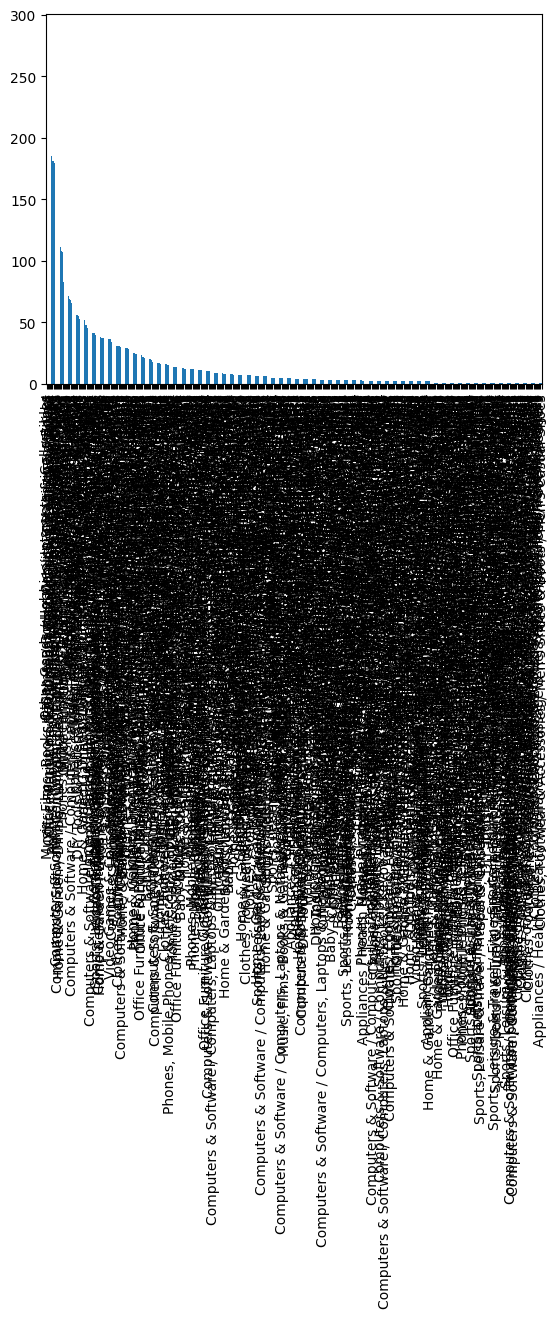

In [5]:
df['category'].value_counts().plot(kind='bar')

Texts for Classification

These are some of the fields we can use for the classification task. We create 3 different versions.

In [6]:
#just the description
df['pdt_name'] = df['product_name']

#description + headline
df['pdt_name_desc'] = df['product_name'] + ' '+ df['product_description']

#description + headline + category
df['pdt_name_desc_cat'] = df['product_name'] + ' '+ df['product_description'] + ' '+ df['category']

In [7]:
def _reciprocal_rank(true_labels: list, machine_preds: list):
    """Compute the reciprocal rank at cutoff k"""
    
    # add index to list only if machine predicted label exists in true labels
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_preds) if r in true_labels]

    rr = 0
    if len(tp_pos_list) > 0:
        # for RR we need position of first correct item
        first_pos_list = tp_pos_list[0]
        
        # rr = 1/rank
        rr = 1 / float(first_pos_list)

    return rr

def compute_mrr_at_k(items:list):
    """Compute the MRR (average RR) at cutoff k"""
    rr_total = 0
    
    for item in items:   
        rr_at_k = _reciprocal_rank(item[0],item[1])
        rr_total = rr_total + rr_at_k
        mrr = rr_total / 1/float(len(items))

    return mrr

def collect_preds(Y_test,Y_preds):
    """Collect all predictions and ground truth"""
    
    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y_preds)]
    return pred_gold_list
             
def compute_accuracy(eval_items:list):
    correct=0
    total=0
    
    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])
        
        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break
    
    
    accuracy=correct/float(len(eval_items))
    return accuracy

In [3]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import preprocessing
from sklearn import utils

import numpy as np
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    
    logging.info("Extracting features and creating vocabulary...")
    
    if "binary" in type:
        
        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    elif "counts" in type:
        
        # COUNT BASED FEATURE REPRESENTATION
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    else:    
        
        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

def get_top_k_predictions(model,X_test,k):
    
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)

    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]
    
    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    
    preds=[ item[::-1] for item in preds]
    
    return preds

def train_model(df,field="'pdt_name_desc_cat'",feature_rep="binary",top_k=3):
    
    logging.info("Starting model training...")

    # GET LABELS
    ohe = preprocessing.OneHotEncoder()
    price = df['price'].values.reshape(-1,1)
    y = ohe.fit_transform(price)
    
    Y_train = [y]
    Y_test = [y]

    # GET A TRAIN TEST SPLIT (set seed for consistent results)
    # for df['column'] in df:
    #     if df['column'].dtype == object:
    #         df['column'] = ohe.fit_transform(df['column'].values.shape[0])
    #     else:
    #         pass
    # return df 
    X = ohe.fit_transform(df[field].values.reshape(-1,1))
    training_data, testing_data = train_test_split(X,random_state = 2000,)

    # GET FEATURES
    X_train,X_test,feature_transformer=extract_features(X,field,training_data,testing_data,type=feature_rep)

    # INIT LOGISTIC REGRESSION CLASSIFIER
    logging.info("Training a Logistic Regression Model...")
    scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
    model=scikit_log_reg.fit(X_train,Y_train)

    # GET TOP K PREDICTIONS
    preds=get_top_k_predictions(model,X_test,top_k)
    
    # GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS - for ease of evaluation
    eval_items=collect_preds(Y_test,preds)
    
    # GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    mrr_at_k=compute_mrr_at_k(eval_items)
    
    logging.info("Done training and evaluation.")
    
    return model,feature_transformer,accuracy,mrr_at_k

Train a Single Model
Model - 1 (binary features with name and description only)

In [4]:
field='pdt_name'
feature_rep='binary'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

NameError: name 'df' is not defined

Model - 2 (tfidf features with description only)

In [61]:
field='pdt_name'
feature_rep='tfidf'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2022-10-24 15:01:44,749 : INFO : Starting model training...
2022-10-24 15:01:44,755 : INFO : Extracting features and creating vocabulary...
2022-10-24 15:01:44,831 : INFO : Training a Logistic Regression Model...


AttributeError: 'bool' object has no attribute 'any'

Model - 3 (tfidf features with description, headline, url)

In [1]:
field='pdt_name_desc'
feature_rep='tfidf'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

NameError: name 'train_model' is not defined

In [35]:
ohe = preprocessing.OneHotEncoder()
price = df['price'].values.reshape (1,-1)
encoded = ohe.fit_transform(price)
print(utils.multiclass.type_of_target(encoded))

multilabel-indicator
